# ICLR Reproducability Challenge: Interactive Report

## Gradients Explode - Deep Networks Are Shallow - ResNets Explained

This is an interactive report that contains results and figures from the original paper together with code to reproduce the same results



## Introduction

The original paper sets out to show that techniques such as Adam, batch normalisation and SeLU nonlinearities do not solve the exploding gradient problem that MLPs can suffer from. The authors go on to show that exploding gradients limit the depth to which neural networks can be effectively trained. Finally, they explain why exploding gradients occur and highlight the collapsing domain problem, which can affect neural networks that do not suffer from exploding gradients.

## Notation

#### Neural Network Notation

The authors describe a neural network $f$ as a succession of layers $f_l$, $ 0 \leq l \leq L$. Each of these layers is a vector-to-vector transformation. $f_1$ is the final/output layer, which outputs the prediction of the network, i.e:

\begin{equation*}
\hat{y} = f_1(\theta_1, f_2(\theta_2, f_3(\dots f_L(\theta_L, x)\dots)))
\end{equation*}

The goal is to minimise the value of the error/loss layer $f_0$ over the network's prediction and the true label $y$, summed over some dataset $D$.

\begin{equation*}
\underset{\theta}{\operatorname{argmin}} E = \frac{1}{|D|}\sum_{(x,y)\in D}f_0(y, f_1(\theta_1, f_2(\theta_2, f_3(\dots f_L(\theta_L, x)\dots))))
\end{equation*}

#### Quadratic Expectation

Let the quadratic expectation $\mathbb{Q}$ of a random variable $X$ be defined as

\begin{equation*}
\mathbb{Q}[X] = \mathbb{E}[X^2]^{\frac{1}{2}}
\end{equation*}

This is the generalisation of quadratic mean to random variables. Let the inverse quadratic expectation $\mathbb{Q}^{-1}$ of a random variable $X$ be defined as

\begin{equation*}
\mathbb{Q}^{-1}[X] = \mathbb{E}[X^{-2}]^{-\frac{1}{2}}
\end{equation*}

#### Quadratic Mean Norm

Let the quadratic mean norm or qm norm of an $m \times n$ matrix $A$ be the quadratic mean of its singular values where the sum of squares is divided by its right dimension $n$. If $s_1, s_2, \dots, s_{\mathrm{min}(m,n)}$ are the singular values of $A$, we write:

\begin{equation*}
||A||_{qm} = \sqrt{\frac{s_1^2 + s_2^2 + \cdots + s_{\mathrm{min}(m,n)}^2}{n}}
\end{equation*}

It measures the expected impact the matrix has on the length of a vector with uniformly random orientation

#### Jacobians

Let $\mathcal{J}_k^l(\theta, x, y)$ be the Jacobian of the $l$th layer $f_l$ with respect to the $k$th layer $f_k$ evaluated with parameter $\theta$ at $(x,y)$, where $0 \leq l \leq k \leq L$

Let $\mathcal{T}_k^l(\theta, x, y)$ be the Jacobian of the $l$th layer $f_l$ with respect to the parameter sub-vector of the $k$th layer $\theta_k$

## Gradient Scale Coefficients (GSCs)

The authors propose the Gradient Scale Coefficient as a means of assessing whether a network has pathological exploding gradients. It is robust to network scaling and layer width and can be used directly to show that training is difficult.

#### GSC Definition

Let the gradient scale coefficient for $0 \leq l \leq k \leq L$ be as follows:

\begin{equation*}
GSC(k,l,f,\theta,x,y) = \frac{||\mathcal{J}_k^l||_{qm}^2||f_k||_2^2}{||f_l||_2^2}
\end{equation*}

The GSC combines the norm of the Jacobian with the ratio of the lengths of the forward activation
vectors. In plain language, it measures the size of the gradient flowing backward relative to the size
of the activations flowing forward. Equivalently, it measures the relative sensitivity of layer l with
respect to small random changes in layer k

#### Exploding Gradients

The authors propose the following definition of exploding gradients using the GSC. The network $f(\theta)$ has exploding gradients with rate $r$ and intercept $c$ at some point $(x,y)$ if for all $k$ and $l$ we have $GSC(k,l,f,\theta,x,y) \geq cr^{k-l}$, and in particular $GSC(l,0,f,\theta,x,y) \geq cr^{l}$

## Residual Neural Network and ResNets
Similar to a standard neural network, the authors introduce the concept of a residual neural network which akin to the traditional neural network, referred to in the paper as a 'vanilla network' is a succession of layers with $f_1$ as the final/output layer. Each layer, apart from $f_0$, the error layer, is the sum of a fixed initial function $i_l$ and a residual function $r_l$. Here, the prediction of the network is

\begin{equation*}
\hat{y} = f_1(i_1 + r_1(\theta_1), f_2(i_2 + r_2(\theta_2), f_3(\dots f_L(i_L + r_L(\theta_L), x)\dots)))
\end{equation*}

This is minimised in a similar fashion to a vanilla network, by minimising the loss on the error layer, $f_0$

#### ResNets
ResNets are a special subset of residual neural networks which use a skip connection where an output from one layer $f_i$ is fed into the input of another layer $f_{i+x}$ along with the output of $f_{i+x-1}$. This is known as a residual block and $x$ is typically equal to 2 or 3. It can therefore be seen that the residual function is simply
\begin{equation*}
r_l(\theta_l) = f_l(\theta_l) + f_{l-x}(\theta_{l-x})
\end{equation*}

More generally, we can refer to $f_b$
\begin{equation*}
f_b = \rho_b + s_b
\end{equation*}

Where $\rho_b$ is value computed by the block function and $s_b$ is the value computed by the skip connection. We point to a concept $k$ where

\begin{equation*}
k \propto \frac{||s_b||}{||\rho_b||}
\end{equation*}

It is therefore said that $f_b$ is $k$-diluted. Diluting the function by a factor of $k$ does not just reduce the growth of the GSC by a factor of $k$ but by a factor of $k^2 + 1$. A reduction in the GSC this large shows how even small dilutions can drasticaly reduce the problem of exploding gradients

# Experiments

## Gradients Explode - Despite Bounded Activation Functions

In this first experiment, the authors show that exploding gradients exist in MLPs despite the presence of bounded activation functions. They test 7 different MLPs: one with ReLU activations; one with layer normalisation followed by ReLU; one with batch normalisation followed by ReLU; one with tanh activations; one with layer normalisation followed by tanh; one with batch normalisation followed by tanh and one with SeLU activations. All 7 networks had 50 layers with 100 neurons each. The inputs and labels were gaussian noise.

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys

In [0]:
class MLP(nn.Module):
    """
    Creates an MLP with a built-in method to compute it's gradient
    scale coefficients
    """
    
    def __init__(self, activation, layer_norm=False, batch_norm=False):
        super(MLP, self).__init__()
        if layer_norm and batch_norm:
            raise MemoryError('Only one of layer norm and batch norm' + \
                              ' can be true')
        self.activation = activation
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm
        self.layers = nn.ModuleList()
        for i in range(50):
            self.layers.append(nn.Linear(100, 100, bias=False))
        if self.activation == F.relu:
            for layer in self.layers:
                layer.weight.data = torch.tensor(2/100).pow(0.5)*torch.randn((100,100))
        elif self.activation == torch.tanh:
            for layer in self.layers:
                layer.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn((100,100))
        elif self.activation == torch.selu:
            for layer in self.layers:
                layer.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn((100,100))
    
    def forward(self, x):
        if self.layer_norm:
            for i in range(len(self.layers)):
                x = self.activation(self.lnorm(self.layers[i](x)))
        elif self.batch_norm:
            for i in range(len(self.layers)):
                x = self.activation(self.bnorm(self.layers[i](x)))
        else:
            for i in range(len(self.layers)):
                x = self.activation(self.layers[i](x))
        return x
    
    def bnorm(self, x):
        mu = x.mean(dim=0)
        sigma = x.std(dim=0)
        x = (x - mu) / sigma
        return x
    
    def lnorm(self, x):
        mu = x.mean(dim=1).view(x.size(0),1)
        sigma = x.std(dim=1).view(x.size(0),1)
        x = (x - mu) / sigma
        return x
    
    def get_gsc(self, k, l, x, y):
        """
        Computes the gradient scale coefficient for layers k and l for
        input x and target y
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        intermediates = []
        batch_size = x.size(0)
        x = x.clone().detach().requires_grad_(True)
        if self.layer_norm:
            for i in range(len(self.layers)):
                x = self.activation(self.lnorm(self.layers[i](x)))
                intermediates.append(x)
        if self.batch_norm:
            for i in range(len(self.layers)):
                x = self.activation(self.bnorm(self.layers[i](x)))
                intermediates.append(x)
        else:
            for i in range(len(self.layers)):
                x = self.activation(self.layers[i](x))
                intermediates.append(x)
        x = torch.mul(x,y).sum(1)
        intermediates.append(x)
        intermediates = intermediates[::-1]
        
        fl = intermediates[l]
        fk = intermediates[k]
        
        if l != 0:
            fl_dim = fl.size(1)
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.zeros((fl_dim, fk_dim))
                for i in range(fl_dim):
                    J[i] += torch.autograd.grad(intermediates[l][b][i],
                                                intermediates[k],
                                                retain_graph=True)[0].flatten()
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        else:
            fl_dim = 1
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.autograd.grad(intermediates[l][b],
                                        intermediates[k],
                                        retain_graph=True)[0]
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        qe_J_norm = self.quadratic_expectation(J_norms)
        qe_k_norm = self.quadratic_expectation(k_norms)
        qe_l_norm = self.quadratic_expectation(l_norms)
        gsc = (qe_J_norm * qe_k_norm) / qe_l_norm
        return gsc
    
    def get_stds(self, x, y):
        """
        Computes the pre activation standard deviations
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        stds = torch.zeros(50)
        signs = torch.zeros(50)
        batch_size = x.size(0)
        if self.layer_norm:
            for i in range(len(self.layers)):
                x = self.lnorm(self.layers[i](x))
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        elif self.batch_norm:
            for i in range(len(self.layers)):
                x = self.bnorm(self.layers[i](x))
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        else:
            for i in range(len(self.layers)):
                x = self.layers[i](x)
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        return stds, signs
    
    def l2_norm(self, a):
        """
        Computes the L2 norm of vector a, i.e. square root of the sum of each
        element of a squared
        """
        norm = a.pow(2).sum().pow(0.5)
        return norm
    
    def qm_norm(self, A):
        """
        Computes the quadratic mean norm of matrix A
        """
        U, s, V = torch.svd(A)
        sum_sq = s.pow(2).sum()
        norm = torch.sqrt(sum_sq / A.size(1))
        return norm
    
    def quadratic_expectation(self, x):
        """
        Computes the quadratic mean norm of vector x
        """
        expectation = x.pow(2).mean().pow(0.5)
        return expectation

def generate_dataset(obs, mean, var):
    x = mean + (var**0.5)*torch.randn((obs, 100))
    x = 10 * x / x.pow(2).sum(1).pow(0.5).view(obs, 1)
    y = mean + (var**0.5)*torch.randn((obs, 100))
    return x, y

Network 7	Depth: 50    

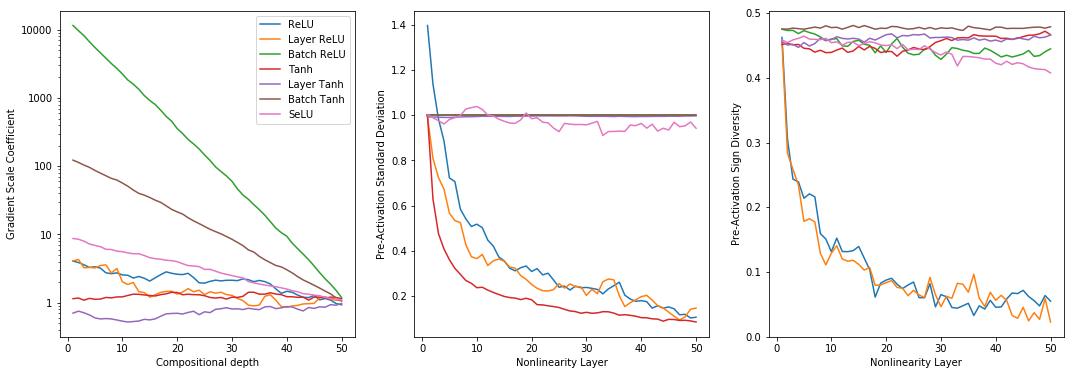

In [0]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
inputs, targets = generate_dataset(100, 0, 1/100)
inputs = inputs.to(device)
targets = targets.to(device)
depths = []
layers = []
gscs = []
stds = []
signs = []
activations = [F.relu, F.relu, F.relu, torch.tanh, torch.tanh, torch.tanh, torch.selu]
layer_norms = [False, True, False, False, True, False, False]
batch_norms = [False, False, True, False, False, True, False]
labels = ['ReLU', 'Layer ReLU', 'Batch ReLU', 'Tanh', 'Layer Tanh', 'Batch Tanh', 'SeLU']
for i in range(len(activations)):
    network = MLP(activations[i],
                  layer_norms[i],
                  batch_norms[i]).to(device)
    d = []
    l = []
    g = []
    for j in range(1,51):
        sys.stdout.write('\rNetwork %d\tDepth: %d    ' % (i+1, j))
        sys.stdout.flush()
        d.append(51-j)
        l.append(j)
        g.append(network.get_gsc(j, 0, inputs, targets).cpu())
    depths.append(d)
    layers.append(l)
    gscs.append(g)
    std, sign = network.get_stds(inputs, targets)
    std = std.data.numpy()
    sign = sign.data.numpy()
    stds.append(std)
    signs.append(sign)

fig, ax = plt.subplots(figsize=(18,6), nrows=1, ncols=3)
for i in range(len(activations)):
    ax[0].plot(depths[i], gscs[i], label=labels[i])
    ax[1].plot(layers[i], stds[i], label=labels[i])
    ax[2].plot(layers[i], signs[i], label=labels[i])
ax[0].set_yscale('log')
ax[0].set_yticks([1,10,100,1000,10000])
ax[0].set_yticklabels([1,10,100,1000,10000])
ax[0].set_xlabel('Compositional depth')
ax[0].set_ylabel('Gradient Scale Coefficient')
ax[0].legend()
ax[1].set_xlabel('Nonlinearity Layer')
ax[1].set_ylabel('Pre-Activation Standard Deviation')
ax[2].set_xlabel('Nonlinearity Layer')
ax[2].set_ylabel('Pre-Activation Sign Diversity')
plt.show()

In [0]:
network.layers[0].weight.size()

torch.Size([100, 100])

The reproduced results are largely the same as the results from the original paper. However, in the original paper the gradient scale coefficients of the Layer Tanh network suggested that it suffered from exploding gradients whereas in this reproduction the gradient scale coefficients are roughly 1 at each compositional depth.

## Exploding Gradients Limit Depth - The Residual Trick

In this section of the paper, the authors introduce effective depth and do some things with CIFAR10

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import sys

In [0]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0, 0, 0), (1, 1, 1)),
    transforms.Lambda(lambda x: x.view(-1))
])

trainset = CIFAR10(".", train=True, download=True, transform=transform)

Files already downloaded and verified


In [0]:
trainloader = DataLoader(trainset, batch_size=1000, shuffle=True)
gscloader = DataLoader(trainset, batch_size=50000, shuffle=True)

In [0]:
class MLP(nn.Module):
    """
    Creates an MLP with a built-in method to compute it's gradient
    scale coefficients
    """
    
    def __init__(self, activation, layer_norm=False, batch_norm=False):
        device = "cuda:0" if torch.cuda.is_available() else "cpu"
        super(MLP, self).__init__()
        if layer_norm and batch_norm:
            raise MemoryError('Only one of layer norm and batch norm' + \
                              ' can be true')
        self.activation = activation
        self.batch_norm = batch_norm
        self.layer_norm = layer_norm
        self.fc1 = nn.Linear(3072, 100, bias=False)
        if self.activation == F.relu:
            self.fc1.weight.data = torch.tensor(2/100).pow(0.5)*torch.randn(self.fc1.weight.size())
        elif self.activation == torch.tanh:
            self.fc1.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn(self.fc1.weight.size())
        elif self.activation == torch.selu:
            self.fc1.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn(self.fc1.weight.size())
        self.layers = nn.ModuleList()
        for i in range(49):
            self.layers.append(nn.Linear(100, 100, bias=False))
        if self.activation == F.relu:
            for layer in self.layers:
                layer.weight.data = torch.tensor(2/100).pow(0.5)*torch.randn((100,100))
        elif self.activation == torch.tanh:
            for layer in self.layers:
                layer.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn((100,100))
        elif self.activation == torch.selu:
            for layer in self.layers:
                layer.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn((100,100))
        self.fc2 = nn.Linear(100, 10, bias=False)
        if self.activation == F.relu:
            self.fc2.weight.data = torch.tensor(2/100).pow(0.5)*torch.randn(self.fc2.weight.size())
        elif self.activation == torch.tanh:
            self.fc2.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn(self.fc2.weight.size())
        elif self.activation == torch.selu:
            self.fc2.weight.data = torch.tensor(1/100).pow(0.5)*torch.randn(self.fc2.weight.size())
    
    def forward(self, x):
        if self.layer_norm:
            x = self.activation(self.lnorm(self.fc1(x)))
            for i in range(len(self.layers)):
                x = self.activation(self.lnorm(self.layers[i](x)))
        elif self.batch_norm:
            x = self.activation(self.bnorm(self.fc1(x)))
            for i in range(len(self.layers)):
                x = self.activation(self.bnorm(self.layers[i](x)))
        else:
            x = self.activation(self.fc1(x))
            for i in range(len(self.layers)):
                x = self.activation(self.layers[i](x))
        x = F.softmax(self.fc2(x), dim=1)
        return x
    
    def bnorm(self, x):
        mu = x.mean(dim=0)
        sigma = x.std(dim=0)
        x = (x - mu) / sigma
        return x
    
    def lnorm(self, x):
        mu = x.mean(dim=1).view(x.size(0),1)
        sigma = x.std(dim=1).view(x.size(0),1)
        x = (x - mu) / sigma
        return x
    
    def get_gsc(self, k, l, x, y):
        """
        Computes the gradient scale coefficient for layers k and l for
        input x and target y
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        intermediates = []
        batch_size = x.size(0)
        x = x.clone().detach().requires_grad_(True).to(device)
        if self.layer_norm:
            x = self.activation(self.lnorm(self.fc1(x)))
            intermediates.append(x)
            for i in range(len(self.layers)):
                x = self.activation(self.lnorm(self.layers[i](x)))
                intermediates.append(x)
        if self.batch_norm:
            x = self.activation(self.bnorm(self.fc1(x)))
            intermediates.append(x)
            for i in range(len(self.layers)):
                x = self.activation(self.bnorm(self.layers[i](x)))
                intermediates.append(x)
        else:
            x = self.activation(self.fc1(x))
            intermediates.append(x)
            for i in range(len(self.layers)):
                x = self.activation(self.layers[i](x))
                intermediates.append(x)
        x = F.softmax(self.fc2(x), dim=1)
        intermediates.append(x)
        x = torch.log(x)
        intermediates.append(x)
        intermediates = intermediates[::-1]
        
        fl = intermediates[l]
        fk = intermediates[k]
        
        fl_dim = fl.size(1)
        fk_dim = fk.size(1)
        J_norms = torch.zeros(batch_size).to(device)
        k_norms = torch.zeros(batch_size).to(device)
        l_norms = torch.zeros(batch_size).to(device)
        for b in range(batch_size):
            J = torch.zeros((fl_dim, fk_dim*batch_size)).to(device)
            for i in range(fl_dim):
                J[i] += torch.autograd.grad(intermediates[l][b][i],
                                            intermediates[k],
                                            retain_graph=True)[0].flatten()
            J_norms[b] = self.qm_norm(J).item()
            k_norms[b] = self.l2_norm(fk[b]).item()
            l_norms[b] = self.l2_norm(fl[b]).item()
        qe_J_norm = self.quadratic_expectation(J_norms)
        qe_k_norm = self.quadratic_expectation(k_norms)
        qe_l_norm = self.quadratic_expectation(l_norms)
        gsc = (qe_J_norm * qe_k_norm) / qe_l_norm
        return gsc
    
    def get_proper_gsc(self, k, l, x, y):
        """
        Computes the gradient scale coefficient for layers k and l for
        input x and target y
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        intermediates = []
        batch_size = x.size(0)
        x = x.clone().detach().requires_grad_(True).to(device)
        if self.layer_norm:
            x = self.activation(self.lnorm(self.fc1(x)))
            intermediates.append(x)
            for i in range(len(self.layers)):
                x = self.activation(self.lnorm(self.layers[i](x)))
                intermediates.append(x)
        if self.batch_norm:
            x = self.activation(self.bnorm(self.fc1(x)))
            intermediates.append(x)
            for i in range(len(self.layers)):
                x = self.activation(self.bnorm(self.layers[i](x)))
                intermediates.append(x)
        else:
            x = self.activation(self.fc1(x))
            intermediates.append(x)
            for i in range(len(self.layers)):
                x = self.activation(self.layers[i](x))
                intermediates.append(x)
        x = F.softmax(self.fc2(x), dim=1)
        intermediates.append(x)
        x = torch.log(x[torch.arange(y.size(0)),y])
        intermediates.append(x)
        intermediates = intermediates[::-1]
        
        fl = intermediates[l]
        fk = intermediates[k]
        
        if l != 0:
            fl_dim = fl.size(1)
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.zeros((fl_dim, fk_dim))
                for i in range(fl_dim):
                    J[i] += torch.autograd.grad(intermediates[l][b][i],
                                                intermediates[k],
                                                retain_graph=True)[0].flatten().to(device)
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        else:
            fl_dim = 1
            fk_dim = fk.size(1)
            J_norms = torch.zeros(batch_size)
            k_norms = torch.zeros(batch_size)
            l_norms = torch.zeros(batch_size)
            for b in range(batch_size):
                J = torch.autograd.grad(intermediates[l][b],
                                        intermediates[k],
                                        retain_graph=True)[0].to(device)
                J_norms[b] = self.qm_norm(J).item()
                k_norms[b] = self.l2_norm(fk[b]).item()
                l_norms[b] = self.l2_norm(fl[b]).item()
        qe_J_norm = self.quadratic_expectation(J_norms)
        qe_k_norm = self.quadratic_expectation(k_norms)
        qe_l_norm = self.quadratic_expectation(l_norms)
        gsc = (qe_J_norm * qe_k_norm) / qe_l_norm
        return gsc
    
    def get_stds(self, x, y):
        """
        Computes the pre activation standard deviations
        
        In the code below:
            fl is the output of layer l
            fk is the output of layer k
            J is the Jacobian of fl with respect to fk, i.e. J is a matrix
            where the element in row i and column j is the derivative of the
            ith element of fl with respect to the jth element of fk
        """
        stds = torch.zeros(50)
        signs = torch.zeros(50)
        batch_size = x.size(0)
        if self.layer_norm:
            for i in range(len(self.layers)):
                x = self.lnorm(self.layers[i](x))
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        elif self.batch_norm:
            for i in range(len(self.layers)):
                x = self.bnorm(self.layers[i](x))
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        else:
            for i in range(len(self.layers)):
                x = self.layers[i](x)
                neuron_stds = x.std(0)
                layer_stds = self.quadratic_expectation(neuron_stds)
                stds[i] = layer_stds
                positive = (x >= 0).sum(0).float()/batch_size
                negative = (x < 0).sum(0).float()/batch_size
                diversity = torch.min(positive, negative).mean()
                signs[i] = diversity
                x = self.activation(x)
        return stds, signs
    
    def l2_norm(self, a):
        """
        Computes the L2 norm of vector a, i.e. square root of the sum of each
        element of a squared
        """
        norm = a.pow(2).sum().pow(0.5)
        return norm
    
    def qm_norm(self, A):
        """
        Computes the quadratic mean norm of matrix A
        """
        U, s, V = torch.svd(A)
        sum_sq = s.pow(2).sum()
        norm = torch.sqrt(sum_sq / A.size(1))
        return norm
    
    def quadratic_expectation(self, x):
        """
        Computes the quadratic mean norm of vector x
        """
        expectation = x.pow(2).mean().pow(0.5)
        return expectation

In [0]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
network = MLP(torch.selu, False, False).to(device)
counter = 0
for data in gscloader:
    counter += 1
    sys.stdout.write("\rCalcing GSC, batch %d                      " % \
                    (counter))
    sys.stdout.flush()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    intermediates = network.get_proper_gsc(51, 0, inputs, labels)

Calcing GSC, batch 305                      

In [0]:
intermediates[0].size()

torch.Size([1000, 2, 10])

In [0]:
import torch.optim as optim

device = "cuda:0" if torch.cuda.is_available() else "cpu"
network = MLP(torch.selu, False, False).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.SGD(network.parameters(), lr=0.03)
from sklearn.metrics import accuracy_score

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimiser, 'min', 0.333, 5)
lr_changes = 0
prev_lr = 0.03
running_loss = 0
# gscs = []
# gsc = 0
# counter = 0
# for data in gscloader:
#     counter += 1
#     sys.stdout.write("\rCalcing GSC, epoch %d, batch %d                      " % \
#                      (0, counter))
#     sys.stdout.flush()
#     inputs, labels = data
#     inputs, labels = inputs.to(device), labels.to(device)
#     gsc = gsc + (1/counter)*(network.get_proper_gsc(51, 0, inputs, labels) - gsc)
# gscs.append(gsc)

for epoch in range(100):
    if lr_changes >= 11:
        break
    running_loss = 0.0
    running_acc = 0
    num_batches = 0
    for param_group in optimiser.param_groups:
            if prev_lr != param_group['lr']:
                lr_changes += 1
                prev_lr = param_group['lr']
    gsc = 0
    counter = 0
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimiser.zero_grad()
        outputs = network(inputs)
        values, indices = torch.max(outputs, 1)
        running_acc += accuracy_score(labels.cpu(), indices.cpu())
        num_batches += 1
#         loss = loss_function(outputs, labels)
        loss = -1*torch.log(outputs[torch.arange(labels.size(0)),labels]).mean()
        loss.backward()
        optimiser.step()
        # keep track of the loss this epoch
        running_loss += loss.item()
        network.zero_grad()
#     for data in gscloader:
#         counter += 1
#         sys.stdout.write("\rCalcing GSC, epoch %d, batch %d                      " % \
#                          (0, counter))
#         sys.stdout.flush()
#         inputs, labels = data
#         inputs, labels = inputs.to(device), labels.to(device)
#         gsc = gsc + (1/counter)*(network.get_proper_gsc(51, 0, inputs, labels) - gsc)
#     gscs.append(gsc)
    scheduler.step(running_loss)
    running_acc /= num_batches
    running_loss /= num_batches
    sys.stdout.write("\rEpoch %d, loss %4.2f, acc %4.2f, gsc %4.2f" % \
                     (epoch+1, running_loss, running_acc, gsc))
    sys.stdout.flush()

Epoch 100, loss 1.31, acc 0.53, gsc 0.00

In [0]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
network = MLP(torch.tanh, False, True).to(device)
gsc = network.get_gsc(1, 0, inputs, labels)

In [0]:
n = np.arange(len(gscs))
fig, ax = plt.subplots(figsize=(12,6), nrows=1, ncols=1)
ax.plot(n, gscs)
plt.show()

tensor(0.0264)

In [0]:
print(torch.tensor(trainset.data).size())
print(torch.tensor(trainset.targets).size())

torch.Size([50000, 32, 32, 3])
torch.Size([50000])


In [0]:
b_size = 10000
loader = DataLoader(trainset, batch_size=b_size, shuffle=True)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
network = MLP(F.relu, True, False)
counter = 0
for data in loader:
        inputs, labels = data
        outputs = network(inputs)
        loss = -1*torch.log(outputs[torch.arange(b_size),labels]).mean()
        print(loss)
        counter += 1

tensor(2.8051, grad_fn=<MulBackward0>)
tensor(2.7834, grad_fn=<MulBackward0>)
tensor(2.8006, grad_fn=<MulBackward0>)
tensor(2.7956, grad_fn=<MulBackward0>)
tensor(2.8035, grad_fn=<MulBackward0>)


In [0]:
outputs.size()
thing = outputs[torch.arange(b_size),labels]
print(outputs[0])
print(labels[0])
print(thing[0])

tensor([0.0436, 0.0355, 0.2490, 0.0956, 0.2745, 0.0358, 0.0248, 0.0266, 0.1968,
        0.0177], grad_fn=<SelectBackward>)
tensor(3)
tensor(0.0956, grad_fn=<SelectBackward>)
